# EDA of county-level maize yield data from South Sudan


Data is taken from [this Github](https://github.com/AnnaXWang/deep-transfer-learning-crop-prediction). This notebook shows basic plots of the data to assess suitability for predicting crop yield from remote sensing data.

One issue is that the Github doesn't cite the original source so can't assess how accurate or reliable it is.

However, there is a good amount of data: yield for 8 consecutive years, 2010-2017, for every county in South Sudan.

Total land area of South Sudan is 620,000 km$^2$, divided into 79 counties, so 7,800 km$^2$ each on average.

Total land area of Senegal is 197,000 km$^2$, divided into 45 departments, so 4,400 km$^2$ each on average.

# Load data and examine


In [305]:
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
import math
import time

In [294]:
ssud = pd.read_csv("https://raw.githubusercontent.com/AnnaXWang/deep-transfer-learning-crop-prediction/master/code/static_data_files/southsudan_yields_standardized.csv")
ssud.head()

,State,County,Year,Crop,Area planted,Production,Yield,Region1,Region2
0,Central Equatoria,Juba,2010,corn,"37,373","32,888",0.879994,central equatoria,juba
1,Central Equatoria,Kajo Keji,2010,corn,"55,723","66,868",1.200007,central equatoria,kajo keji
2,Central Equatoria,Lainya,2010,corn,"21,508","25,810",1.200018,central equatoria,lainya
3,Central Equatoria,Morobo,2010,corn,"25,099","32,126",1.279970,central equatoria,morobo
4,Central Equatoria,Terekeka,2010,corn,"18,409","16,200",0.880005,central equatoria,terekeka


In [295]:
print("Crops: " + str(set(ssud["Crop"])))
print("Years: " + str(set(ssud["Year"])))
print("Counties alphabetically: " + str(sorted(set(ssud["County"]))))
print("Number of counties (should be 79): " + str(len(set(ssud["County"]))))

Crops: {'corn'}
Years: {2016, 2017, 2010, 2011, 2012, 2013, 2014, 2015}
Counties alphabetically: ['Abiemnhom ', 'Abyei ', 'Akobo ', 'Aweil Centre ', 'Aweil East ', 'Aweil North ', 'Aweil South ', 'Aweil West ', 'Awerial ', 'Ayod ', 'Baliet ', 'Bor South ', 'Budi ', 'Canal/Pigi ', 'Cueibet ', 'Duk ', 'Ezo ', 'Fangak ', 'Fashoda ', 'Gogrial East ', 'Gogrial West ', 'Guit ', 'Ibba ', 'Ikotos ', 'Juba ', 'Jur River ', 'Kajo Keji ', 'Kapoeta East ', 'Kapoeta North ', 'Kapoeta South ', 'Koch ', 'Lafon ', 'Lainya ', 'Leer ', 'Longochuk ', 'Luakpiny/Nasir ', 'Maban ', 'Magwi ', 'Maiwut ', 'Malakal ', 'Manyo ', 'Maridi ', 'Mayendit ', 'Mayom ', 'Melut ', 'Morobo ', 'Mundri East ', 'Mundri West ', 'Mvolo ', 'Nagero ', 'Nyirol ', 'Nzara ', 'Panyijiar ', 'Panyikang ', 'Pariang ', 'Pibor ', 'Pochalla ', 'Raga ', 'Renk ', 'Rubkona ', 'Rumbek Centre ', 'Rumbek East ', 'Rumbek North ', 'Tambura ', 'Terekeka ', 'Tonj East ', 'Tonj North ', 'Tonj South ', 'Torit ', 'Twic ', 'Twic East ', 'Ulang ', 'Uror

In [296]:
# Convert production values from strings to integers
for i, row in enumerate(ssud["Production"]):
  row = int(row.replace(",", ""))
  ssud["Production"].iloc[i] = row

# Remove spaces from end of county names
for i, county in enumerate(ssud["County"]):
  if county[-1] == " ":
    ssud["County"].iloc[i] = county[:-1]

print("Counties alphabetically: " + str(sorted(set(ssud["County"]))))
print("Number of counties (should be 79): " + str(len(set(ssud["County"]))))

Counties alphabetically: ['Abiemnhom', 'Abyei', 'Akobo', 'Aweil Centre', 'Aweil East', 'Aweil North', 'Aweil South', 'Aweil West', 'Awerial', 'Ayod', 'Baliet', 'Bor South', 'Budi', 'Canal/Pigi', 'Cueibet', 'Duk', 'Ezo', 'Fangak', 'Fashoda', 'Gogrial East', 'Gogrial West', 'Guit', 'Ibba', 'Ikotos', 'Juba', 'Jur River', 'Kajo Keji', 'Kapoeta East', 'Kapoeta North', 'Kapoeta South', 'Koch', 'Lafon', 'Lainya', 'Leer', 'Longochuk', 'Luakpiny/Nasir', 'Maban', 'Magwi', 'Maiwut', 'Malakal', 'Manyo', 'Maridi', 'Mayendit', 'Mayom', 'Melut', 'Morobo', 'Mundri East', 'Mundri West', 'Mvolo', 'Nagero', 'Nyirol', 'Nzara', 'Panyijiar', 'Panyikang', 'Pariang', 'Pibor', 'Pochalla', 'Raga', 'Renk', 'Rubkona', 'Rumbek Centre', 'Rumbek East', 'Rumbek North', 'Tambura', 'Terekeka', 'Tonj East', 'Tonj North', 'Tonj South', 'Torit', 'Twic', 'Twic East', 'Ulang', 'Uror', 'Wau', 'Wulu', 'Yambio', 'Yei', 'Yirol East', 'Yirol West']
Number of counties (should be 79): 79


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Plot crop yields

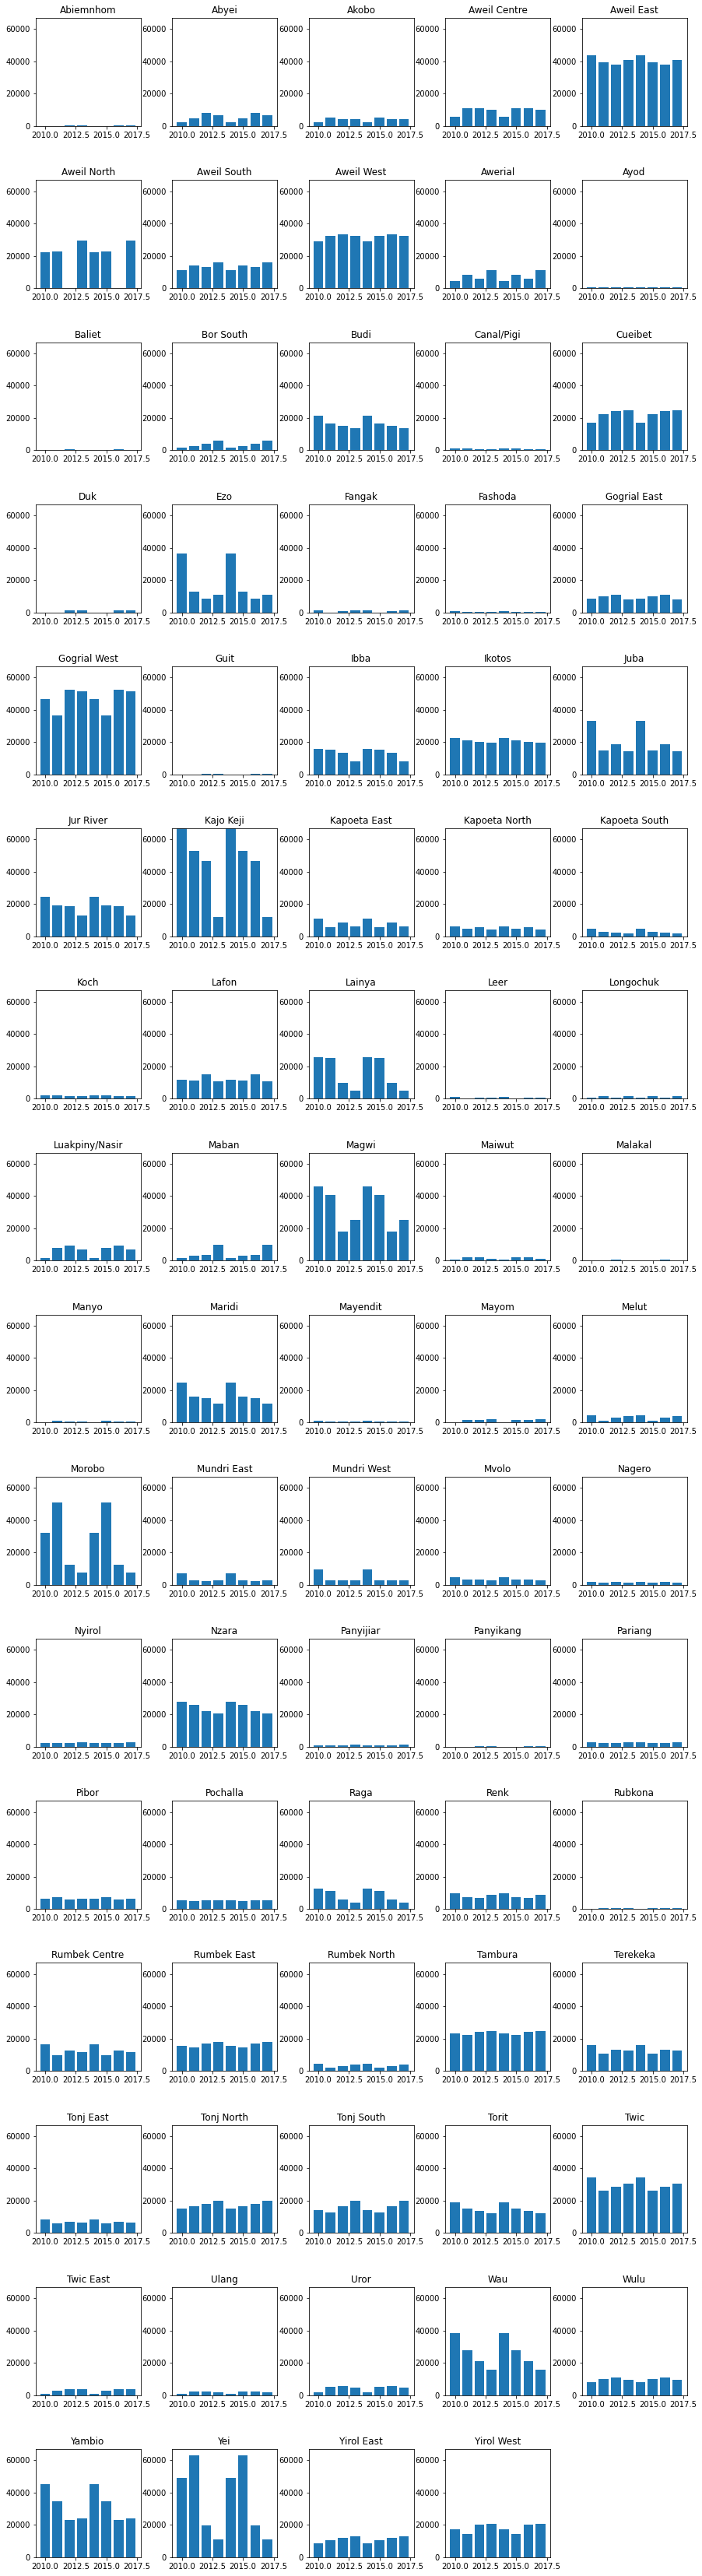

In [297]:
# Plot yield for each county over time

# Set up figure
fig = plt.figure(figsize=(15, 60))
nrows = len(set(ssud["County"]))
ymax = ssud["Production"].max()

# Set up variable for recording how many years' data for each county
n_years = []

# Find unique counties
for i, county in enumerate(sorted(set(ssud["County"]))):

  # Set up empty dataframe for yield values for every year
  df = pd.DataFrame(index=set(ssud["Year"]), columns=["Production"], data=0)

  # Find all data for county
  county_data = ssud.loc[ssud["County"]==county, :]

  # Record number of years for which there is data
  n_years.append(len(county_data))

  # Put available data into empty dataframe
  for _, c in county_data.iterrows():
    df.loc[c["Year"]] = c["Production"]

  # Plot
  ax = fig.add_subplot(math.ceil(nrows/5), 5, i+1)
  ax.bar(df.index, df["Production"])
  plt.ylim(0, ymax)
  plt.subplots_adjust(hspace=0.5, wspace=0.3)
  plt.title(county)


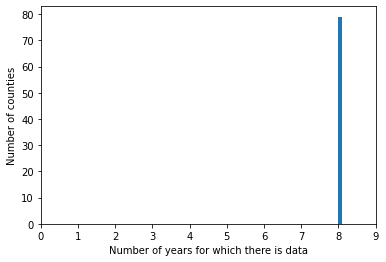

In [298]:
# Plot how much data for each county
plt.hist(n_years)
plt.xlabel('Number of years for which there is data')
plt.ylabel('Number of counties')
plt.xlim(0, len(set(ssud["Year"]))+1);

In [299]:
# Load GeoJSON for plotting maps
county_json = "https://data.kimetrica.com/dataset/79e631b6-86f2-4fc8-8054-31c17eac1e3f/resource/913ec657-3184-4bb1-8f13-614dc1341e16/download/ss_county_boundaries.geojson"
ssud_json = requests.get(county_json).json()

# Make county names consistent
for i in range(len(ssud_json["features"])):
  ssud_json["features"][i]["properties"]["ADMIN2NAME"] = ssud_json["features"][i]["properties"]["ADMIN2NAME"].replace("Abyei region", "Abyei")
  ssud_json["features"][i]["properties"]["ADMIN2NAME"] = ssud_json["features"][i]["properties"]["ADMIN2NAME"].replace("Kajo-keji", "Kajo Keji")

# List of county names from JSON
json_names = [ssud_json["features"][i]["properties"]["ADMIN2NAME"] for i in range(len(ssud_json["features"]))]

# Check for any county names which don't appear in JSON
for i, county in enumerate(set(ssud["County"])):

  # Check if name appears
  if county not in json_names:
    print(county, "missing")

# Check for any JSON county names which don't appear in data
for i, county in enumerate(json_names):

  # Check if name appears
  if county not in set(ssud["County"]):
    print(county, "missing")

In [316]:
# Plot choropleths of crop yield for each year

def plot_map(year):
  map = folium.Map(location=[7, 31], zoom_start=6, width=500,height=500)

  folium.Choropleth(
      geo_data=ssud_json,
      data=ssud[ssud["Year"]==int(year)],
      columns=["County", "Production"],
      key_on='feature.properties.ADMIN2NAME',
      fill_color='YlGnBu',
      legend_name="Maize yield, "+year
  ).add_to(map)

  return map

map = plot_map("2010")
map

In [317]:
map = plot_map("2017")
map